# DEAP Evaluation

Using leave one subject out, evaluate EEG-only spectral power and topo-based features.

In [1]:
import sys
sys.path.insert(0, "../")
save_prefix = "deap"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, pickle
from tqdm import tqdm
from joblib import Parallel, delayed

from libs.dataloaders import deap

from sklearn.decomposition import PCA

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hktqj27i because the default path (/home/anp054/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def per_subject_cv(dataset, subject_sessions:list, model:list, n_jobs=12):
    """
    Run per subject validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, dataset_feats+1))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            X_train_vgg = np.array([i[0].flatten() for i in train_data])
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([dataset[test_idx][0].flatten(), ])
            Y_test_vgg = np.array(dataset[test_idx][1])*2-1 # rescale to -1, 1
            
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_vgg.shape[0]))
            X_train_vgg = X_train_vgg[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [4]:
class RandomProjection:
    def __init__(self, n_components, center=0, scale=None):
        self.n_components = n_components
        self.projection_matrix = None
        self._center = center
        self._scale = scale

    def fit(self, data):
        if self._scale is None:
            self._scale = 1 / np.sqrt(data.shape[1])
        ## Approach 1
        self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1], self.n_components))
        ## Approach 2
        # self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1]*self.n_components,))
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
        ## Approach 3
        # self.projection_matrix = np.zeros((data.shape[1]*self.n_components,))
        # for i in range(0, len(self.projection_matrix), 64_000):
        #     self.projection_matrix[i:i+64_000] = np.random.normal(self._center, self._scale, 64_000)
        # mod = len(self.projection_matrix) % 64_000
        # if mod > 0:
        #     self.projection_matrix[-mod:] = np.random.normal(self._center, self._scale, mod)
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
    
    def transform(self, data):
        return np.dot(data, self.projection_matrix)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [5]:
def per_subject_cv_rp_pc(dataset, subject_sessions:list, model:list, n_jobs=12, nrp=4096):
    """
    Run leave one subject out cross-validation on data transformed by random projection and then projected using PCA
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    @param int nrp - Random Projection component dimensionality
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, nrp))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        # Compute one random projection on all of the data and then permute the projection
        # matrix itself. It takes ~25sec to generate one matrix when >1B samples.
        # This doesn't leak test data as it is just ensuring the sampling dist is centered
        rp_data = [dataset[i] for i in data_idx]
        X_rp = np.array([i[0].flatten() for i in rp_data])
        print(f"Computing Random Projection Matrix ({X_rp.shape[1]}, {nrp})")
        projection = RandomProjection(n_components=nrp)
        projection.fit(X_rp)

        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            X_train_vgg = np.array([i[0].flatten() for i in train_data])
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([dataset[test_idx][0].flatten(), ])
            Y_test_vgg = np.array(dataset[test_idx][1])*2-1 # rescale to -1, 1
            # compute new projection based on original sampling
            np.random.shuffle(projection.projection_matrix) 
            X_train_rp = projection.transform(X_train_vgg)
            X_test_rp = projection.transform(X_test_vgg)
            
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_rp.shape[0]))
            X_train_rp = X_train_rp[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_rp)
            X_train_pc = pca.transform(X_train_rp)
            X_test_pc = pca.transform(X_test_rp)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [6]:
def trainmax2test(train, test):
    '''subject pc bootstrap -> subject bootstrap'''
    ## Max with fewest nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # return np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(test)])

    ## Max with most nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _train = np.flip(_train, axis=1)
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # _test = np.flip(test, axis=1)
    # _test = np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(_test)])
    # _test = np.flip(_test, axis=1)
    # return _test

    ## Max with most nPC
    _train = np.nan_to_num(train, nan=-1.) # hacky way to get around all nan argmax
    _train = np.flip(_train, axis=1)
    _argmax = np.argmax(_train, axis=1) # find max acc per pc
    _test = np.flip(test, axis=1)
    return np.array([[k[_argmax[n_subj, n_k]] for n_k, k in enumerate(subj.T)] for n_subj, subj in enumerate(_test)])

def plot_overview(train, test, ev, dataset=None, dataset_clip=10):
    mdl_accs = trainmax2test(train, test)

    if dataset is not None:
        print(f"Clipping datasets with fewer than {dataset_clip} samples...")
        valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
    else:
        valid_sessions_idx = np.arange(mdl_accs.shape[0])
    
    mdl_accs = mdl_accs[valid_sessions_idx,:]
    mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
    print(np.nanmean(mdl_means))
    mdl_stderr = np.nanstd(mdl_accs, axis=1) / np.sqrt(np.count_nonzero(~np.isnan(mdl_accs), axis=1))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.ylabel("Accuracy")

    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev, axis=-1).T)
    plt.xlabel("Subject")
    plt.ylabel("Exp Var")
    plt.show()

In [7]:
import torch
import torchvision.models as torchmodels
def vgg16_augment(model):
    model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
def inception_augment(model):
    model = torch.nn.Sequential(*list(torchmodels.inception_v3(weights="DEFAULT").children())[:-3])

In [8]:
from functools import partial
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC

lda = partial(LinearDiscriminantAnalysis, priors=[0.5, 0.5])
linear_svm = partial(LinearSVC)
nonlinear_svm = partial(SVC, kernel="rbf")
models = [lda, linear_svm, nonlinear_svm]
reduced_models = [lda, ]

## Average Spectral Power

Here we are looking at the average spectral power of Theta, Alpha, Beta, and Gamma per channel, concatenated together to form the feature vector. The results here are reported for a set of classifiers.

In [7]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "AvgFreqPower", 
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False, # balances by subject
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [02:02<00:00,  3.83s/it]


In [8]:
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:00<00:00, 1946.70it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 3168 out of 3168 | elapsed:    5.6s finished
100%|██████████| 31/31 [00:00<00:00, 995.18it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 1672 tasks  

In [9]:
with open(f"{save_prefix}_result_avgfreqpwr.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [10]:
acc.shape, train_acc.shape, evs.shape

((32, 96, 34), (32, 96, 34), (32, 96))

Clipping datasets with fewer than 10 samples...
0.6104105170196863


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


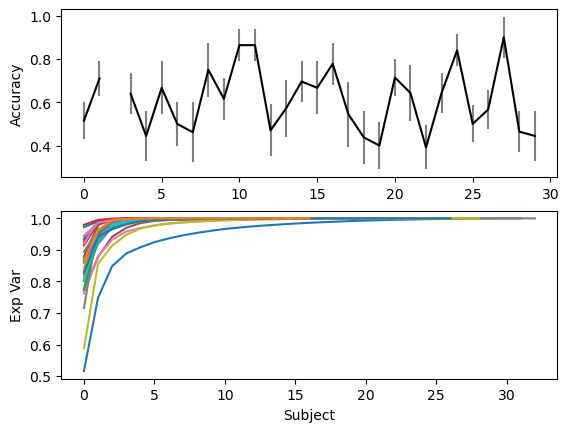

In [11]:
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)

## Spectrogram Image Feature - VGG16

In [9]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "Spectrogram", 
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

  0%|          | 0/32 [00:00<?, ?it/s][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    6.7s finished
  3%|▎         | 1/32 [00:59<30:48, 59.62s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    6.1s finished
  6%|▋         | 2/32 [01:58<29:38, 59.30s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    5.9s finished
  9%|▉         | 3/32 [02:56<28:18, 58.58s/it][Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed:    6.0s finished


In [10]:
train_acc_specto, acc_specto, evs_specto = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:39<00:00,  1.21s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.9s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.4s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [11]:
with open(f"{save_prefix}_result_specto_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto, 
                 "train_acc": train_acc_specto, 
                 "ev": evs_specto}, fout)

Clipping datasets with fewer than 10 samples...
0.6006377662235906


/tmp/ipykernel_133425/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


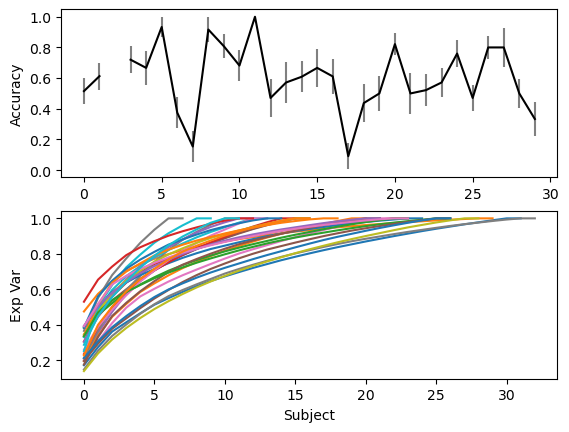

In [12]:
plot_overview(train_acc_specto, acc_specto, evs_specto, dataset, dataset_clip=10)

### PCA(RP_4096(Spectogram))

In [13]:
train_acc_specto_rp_pc, acc_specto_rp_pc, ev_specto_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=24, nrp=4096)

  0%|          | 0/32 [00:00<?, ?it/s]

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 33/33 [01:13<00:00,  2.22s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.8s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   15.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 31/31 [01:07<00:00,  2.19s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.5s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.0s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.6s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 25/25 [00:51<00:00,  2.07s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 25/25 [00:52<00:00,  2.11s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 18/18 [00:35<00:00,  1.98s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.4s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 18/18 [00:35<00:00,  1.98s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    5.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    6.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    8.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   10.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 24/24 [00:49<00:00,  2.05s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.7s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.3s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 13/13 [00:24<00:00,  1.90s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.8s
[Parallel(n_jobs=24)]: Done 8632 out of 8632 | elapsed

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 6/6 [00:10<00:00,  1.78s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 3984 out of 3984 | elapsed:    0.3s finished
 28%|██▊       | 9/32 [11:10<20:36, 53.75s/it]

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 15/15 [00:28<00:00,  1.92s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    5.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    7.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 26/26 [00:55<00:00,  2.13s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.2s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.7s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.2s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 22/22 [00:45<00:00,  2.05s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 25/25 [00:50<00:00,  2.03s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.5s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.9s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.3s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   11.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 17/17 [00:32<00:00,  1.92s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 14/14 [00:27<00:00,  1.94s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.4s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.4s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    5.7s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.2s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    8.8s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.6s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done 9296 out of 9296 | elapsed

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 23/23 [00:47<00:00,  2.08s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 15/15 [00:29<00:00,  1.96s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.9s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 9/9 [00:16<00:00,  1.81s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    5.9s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.3s
[Parallel(n_jobs=24)]: Done 5976 out of 5976 | elapsed:    8.8s finished
 56%|█████▋    | 18/32 [21:02<13:05, 56.13s/it]

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 18/18 [00:35<00:00,  1.97s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.0s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.8s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 11/11 [00:20<00:00,  1.88s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.8s
[Parallel(n_jobs=24)]: Done 7304 out of 7304 | elapsed:   11.0s finished
 62%|██████▎   | 20/32 [22:48<10:40, 53.37s/

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 16/16 [00:31<00:00,  1.95s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.1s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 20/20 [00:39<00:00,  1.98s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.3s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 28/28 [01:01<00:00,  2.20s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.3s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 14/14 [00:27<00:00,  1.93s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.2s
[Parallel(n_jobs=24)]: Done 9296 out of 9296 | elapsed

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 23/23 [00:47<00:00,  2.08s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.1s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 28/28 [01:00<00:00,  2.16s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.1s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 25/25 [00:52<00:00,  2.08s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.7s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.2s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 34/34 [01:15<00:00,  2.23s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.1s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 30/30 [01:05<00:00,  2.18s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.9s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 13/13 [00:24<00:00,  1.87s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    3.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:    9.9s
[Parallel(n_jobs=24)]: Done 8632 out of 8632 | elapsed

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 28/28 [01:01<00:00,  2.20s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.9s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.1s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.8s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.9s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (131072, 4096)



100%|██████████| 18/18 [00:35<00:00,  1.95s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.1s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

In [14]:
with open(f"{save_prefix}_result_specto_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto_rp_pc, 
                 "train_acc": train_acc_specto_rp_pc, 
                 "ev": ev_specto_rp_pc}, fout)

Clipping datasets with fewer than 10 samples...
0.6006312006080291


/tmp/ipykernel_133425/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


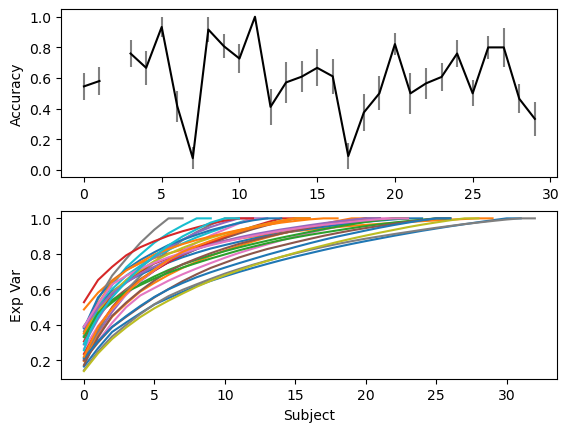

In [15]:
plot_overview(train_acc_specto_rp_pc, acc_specto_rp_pc, ev_specto_rp_pc, dataset, dataset_clip=10)

## Topo Features

Following methods outlined [here](https://ieeexplore.ieee.org/abstract/document/8713896/), Theta, Alpha, Beta frequency filtered topo images are combined into the three color channels and fed through pretrained image processing model. The performance results are reported as `Feat_Model -> PCA -> Model` and `Feat_model -> Model` as a function of features (ordered by EV for PCA and bootstrapped otherwise).

### VGG16

In [ ]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

 59%|█████▉    | 19/32 [02:38<01:48,  8.34s/it]

In [13]:
train_acc_vgg, acc_vgg, evs_vgg = per_subject_cv(dataset, subjects, lda, n_jobs=64)

[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.6s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:   20.2s
[Parallel(n_jobs=64)]: Done 12672 tasks      | elapsed:   23.0s
[Parallel(n_jobs=64)]: Done 14322 tasks      | elapsed:   26.0s
[Parallel(n_jobs=64)]: Done 16072 tasks      | elapsed:   29.1s
[Parallel(n_jobs=64)]: Done 17922 tasks      | elapsed:   32.5s
[Parallel(n_jobs=64)]: Done 19872 tasks      | elapsed:   35.9s
[Parallel(n_jobs=64)]: Done 21912 out of 21912 | elapsed:   39.5s finished
100%|██████████| 31/31 [00:01<00:00, 19.01it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tas

In [14]:
with open(f"{save_prefix}_result_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg, 
                 "train_acc": train_acc_vgg, 
                 "ev": evs_vgg, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.5563146281120929


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


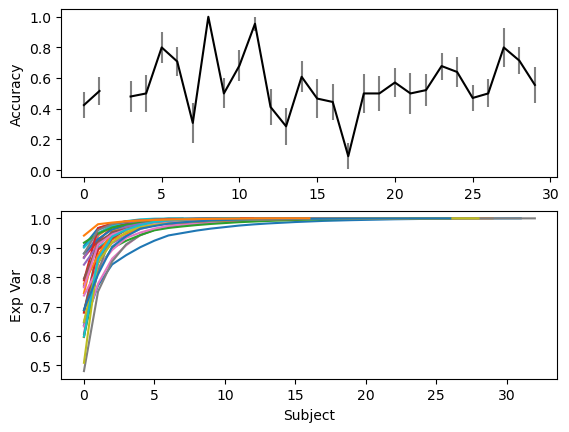

In [15]:
plot_overview(train_acc_vgg, acc_vgg, evs_vgg, dataset, dataset_clip=10)

#### Strawman: Random Initialization
Using the VGG16 model architecture, initialize the weights randomly to measure the impact of architecture versus out-of-distribution trained performance.

In [16]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [04:21<00:00,  8.19s/it]


In [17]:
train_acc_vgg_randinit, acc_vgg_randinit, evs_vgg_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:02<00:00, 12.91it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    8.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    9.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   10.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   13.8s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   15.5s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   17.4s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   19.5s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   21.8s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   24.2s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [18]:
with open(f"{save_prefix}_result_vgg16_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg_randinit, 
                 "train_acc": train_acc_vgg_randinit, 
                 "ev": evs_vgg_randinit, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.6066389702018093


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


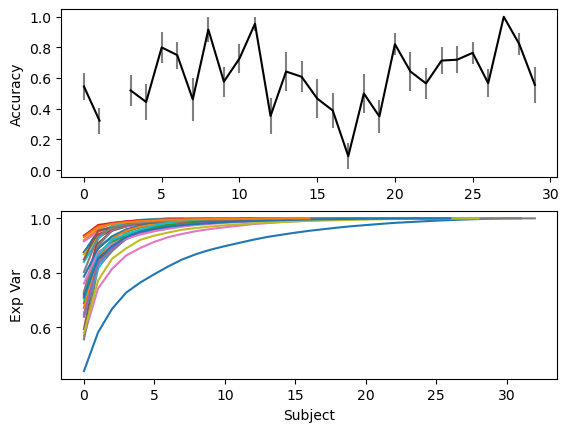

In [19]:
plot_overview(train_acc_vgg_randinit, acc_vgg_randinit, evs_vgg_randinit, dataset, dataset_clip=10)

### AlexNet

In [20]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [03:47<00:00,  7.11s/it]


In [21]:
train_acc_alexnet, acc_alexnet, evs_alexnet = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:01<00:00, 17.66it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.9s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [22]:
with open(f"{save_prefix}_result_alexnet.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet, 
                 "train_acc": train_acc_alexnet,
                 "ev": evs_alexnet, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.6137648639580952


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


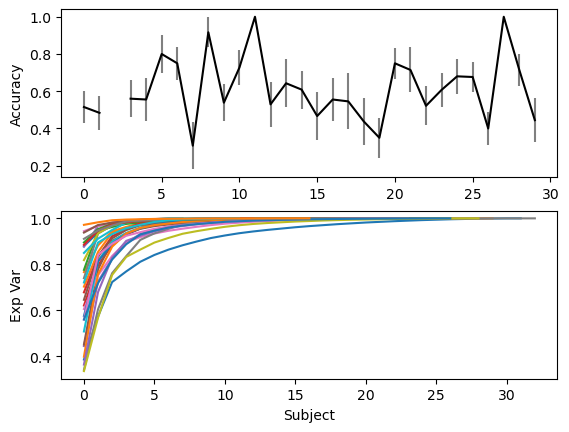

In [23]:
plot_overview(train_acc_alexnet, acc_alexnet, evs_alexnet, dataset, dataset_clip=10)

#### Strawman: Random Initialization

In [24]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [03:50<00:00,  7.21s/it]


In [25]:
train_acc_alexnet_randinit, acc_alexnet_randinit, evs_alexnet_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:02<00:00, 15.82it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.8s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [26]:
with open(f"{save_prefix}_result_alexnet_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet_randinit, 
                 "train_acc": train_acc_alexnet_randinit,
                 "ev": evs_alexnet_randinit, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.6154172341291518


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


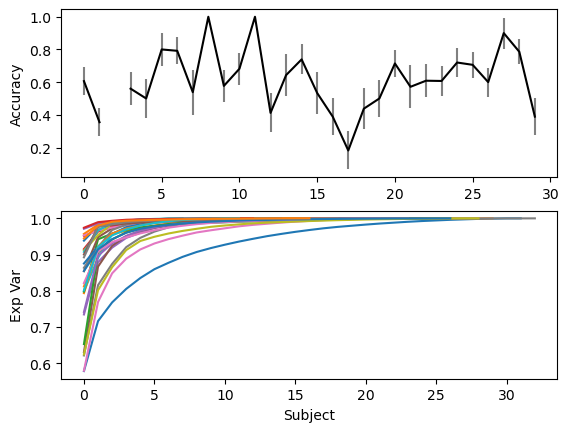

In [27]:
plot_overview(train_acc_alexnet_randinit, acc_alexnet_randinit, evs_alexnet_randinit, dataset, dataset_clip=10)

### InceptionNet v3

In [28]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [04:02<00:00,  7.58s/it]


In [29]:
train_acc_incepv3, acc_incepv3, evs_incepv3 = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:00<00:00, 47.80it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   11.0s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   15.5s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   18.0s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [30]:
with open(f"{save_prefix}_result_incepv3.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3, 
                 "train_acc": train_acc_incepv3,
                 "ev": evs_incepv3, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.5506519724206327


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


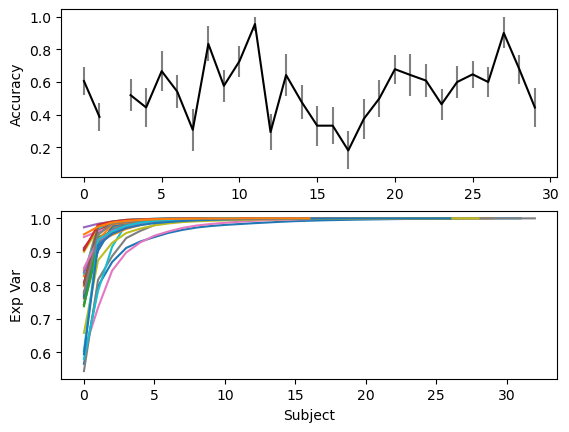

In [31]:
plot_overview(train_acc_incepv3, acc_incepv3, evs_incepv3, dataset, dataset_clip=10)

#### Strawman: Random Initialization

In [32]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [04:05<00:00,  7.68s/it]


In [33]:
train_acc_incepv3_randinit, acc_incepv3_randinit, evs_incepv3_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [00:00<00:00, 44.18it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.7s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.8s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   15.0s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.4s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [34]:
with open(f"{save_prefix}_result_incepv3_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3_randinit,
                 "train_acc": train_acc_incepv3_randinit,
                 "ev": evs_incepv3_randinit, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.5678203905277323


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


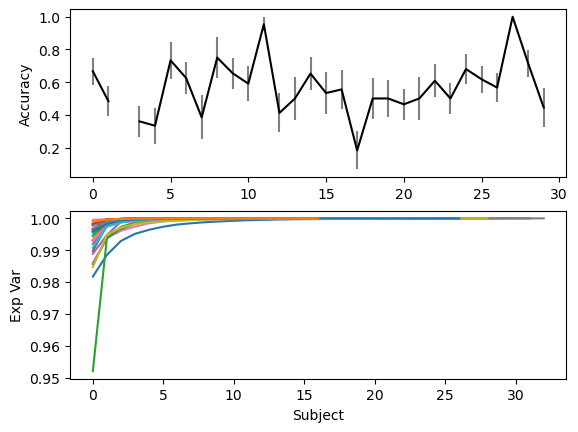

In [35]:
plot_overview(train_acc_incepv3_randinit, acc_incepv3_randinit, evs_incepv3_randinit, dataset, dataset_clip=10)

## Random Projections
Here we explore whether deep feature transformers operate differently than high-dimensional random projections.

In [38]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "TopomapImg",
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [03:52<00:00,  7.27s/it]


### PCA(RP_4096(Topo))

In [39]:
train_acc_rp_pc, acc_rp_pc, ev_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=24, nrp=4096)

  0%|          | 0/32 [00:00<?, ?it/s]

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 33/33 [02:27<00:00,  4.46s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    9.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   13.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   15.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 31/31 [02:16<00:00,  4.40s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.5s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.9s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 25/25 [01:44<00:00,  4.17s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 25/25 [01:45<00:00,  4.20s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.1s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 18/18 [01:11<00:00,  3.99s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.9s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 18/18 [01:11<00:00,  3.97s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    4.4s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    5.9s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    8.3s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   10.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 24/24 [01:41<00:00,  4.24s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 13/13 [00:49<00:00,  3.84s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.1s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.8s
[Parallel(n_jobs=24)]: Done 8632 out of 8632 | elapsed

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 6/6 [00:21<00:00,  3.64s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 3984 out of 3984 | elapsed:    0.4s finished
 28%|██▊       | 9/32 [19:31<36:38, 95.57s/it] 

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 15/15 [01:00<00:00,  4.03s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    7.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    8.9s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   10.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 26/26 [01:50<00:00,  4.26s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.0s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.6s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 22/22 [01:29<00:00,  4.09s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.9s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.1s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 25/25 [01:43<00:00,  4.16s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.0s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.3s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.7s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.3s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    8.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   17.6s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 17/17 [01:09<00:00,  4.06s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.8s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.8s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.1s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.1s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 14/14 [00:55<00:00,  3.95s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.8s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.7s
[Parallel(n_jobs=24)]: Done 9296 out of 9296 | elapsed

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 23/23 [01:35<00:00,  4.15s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.2s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.6s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.1s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.8s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.7s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 15/15 [01:00<00:00,  4.01s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.9s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.2s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 9/9 [00:33<00:00,  3.68s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.9s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.7s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.7s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.0s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.4s
[Parallel(n_jobs=24)]: Done 5976 out of 5976 | elapsed:    9.0s finished
 56%|█████▋    | 18/32 [36:49<22:59, 98.51s/it] 

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 18/18 [01:12<00:00,  4.01s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.2s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.5s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.6s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 11/11 [00:41<00:00,  3.75s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.0s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.4s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.0s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.8s
[Parallel(n_jobs=24)]: Done 7304 out of 7304 | elapsed:   11.0s finished
 62%|██████▎   | 20/32 [39:54<18:42, 93.55s/

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 16/16 [01:02<00:00,  3.92s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.2s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.0s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 20/20 [01:21<00:00,  4.08s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.6s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.5s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.2s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.2s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 28/28 [02:03<00:00,  4.42s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.6s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 14/14 [00:54<00:00,  3.87s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.4s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.4s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    5.8s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.1s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    8.7s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   10.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.4s
[Parallel(n_jobs=24)]: Done 9296 out of 9296 | elapsed

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 23/23 [01:35<00:00,  4.15s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.0s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.2s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.6s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.1s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.7s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.8s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 28/28 [01:58<00:00,  4.23s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.9s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.9s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.6s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.4s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.7s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 25/25 [01:44<00:00,  4.16s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.9s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.6s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.4s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   13.5s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 34/34 [02:30<00:00,  4.43s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.7s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    9.0s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.9s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   13.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   15.4s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 30/30 [02:09<00:00,  4.33s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.2s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.3s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.6s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    7.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.8s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.5s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.5s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.7s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 13/13 [00:50<00:00,  3.88s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.0s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    1.2s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    2.0s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    3.3s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    4.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    6.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:    8.1s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:    9.9s
[Parallel(n_jobs=24)]: Done 8632 out of 8632 | elapsed

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 28/28 [01:58<00:00,  4.23s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.3s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    2.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    3.1s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    5.4s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.9s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    8.5s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:   10.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   12.3s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   14.3s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

Computing Random Projection Matrix (270000, 4096)



100%|██████████| 18/18 [01:12<00:00,  4.02s/it]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    1.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    1.8s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    2.6s
[Parallel(n_jobs=24)]: Done 2402 tasks      | elapsed:    3.6s
[Parallel(n_jobs=24)]: Done 3152 tasks      | elapsed:    4.8s
[Parallel(n_jobs=24)]: Done 4002 tasks      | elapsed:    6.1s
[Parallel(n_jobs=24)]: Done 4952 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done 6002 tasks      | elapsed:    9.3s
[Parallel(n_jobs=24)]: Done 7152 tasks      | elapsed:   11.0s
[Parallel(n_jobs=24)]: Done 8402 tasks      | elapsed:   12.9s
[Parallel(n_jobs=24)]: Done 9752 tasks      | elapsed:

In [40]:
with open(f"{save_prefix}_result_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_rp_pc, 
                 "train_acc": train_acc_rp_pc, 
                 "ev": ev_rp_pc, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.5815649787015456


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


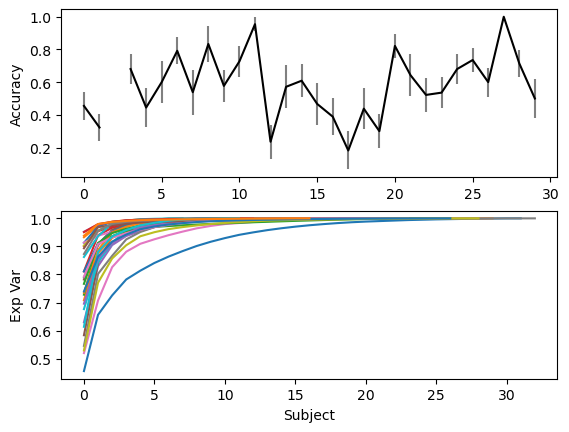

In [41]:
plot_overview(train_acc_rp_pc, acc_rp_pc, ev_rp_pc, dataset, dataset_clip=10)

### Strawman: PCA(Topo) without RP

In [42]:
train_acc_topo, acc_topo, ev_topo = per_subject_cv(dataset, subjects, lda, n_jobs=64)

100%|██████████| 33/33 [01:25<00:00,  2.59s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.8s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.2s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed

In [43]:
with open(f"{save_prefix}_result_topo.pkl", "wb") as fout:
    pickle.dump({"acc": acc_topo,
                 "train_acc": train_acc_topo,
                 "ev": ev_topo, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.5869095796180662


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


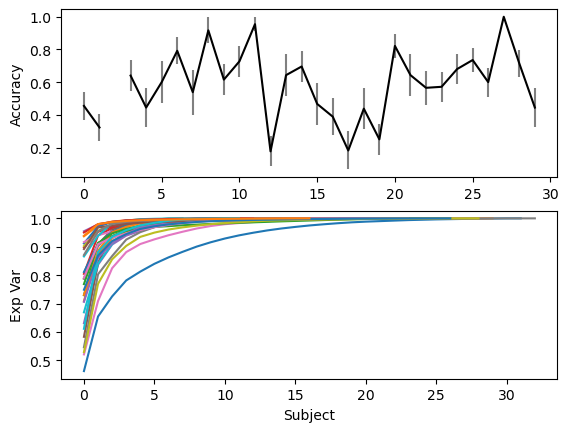

In [44]:
plot_overview(train_acc_topo, acc_topo, ev_topo, dataset, dataset_clip=10)

### PCA(RP_270000(AvgPwr))

In [45]:
dataset = deap.DeapDataset(
    x_params={
        "feature": "AvgFreqPower",
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 32/32 [02:09<00:00,  4.03s/it]


In [46]:
train_acc_avgpwr_rp_pc, acc_avgpwr_rp_pc, ev_avgpwr_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=64, nrp=270000)

  0%|          | 0/32 [00:00<?, ?it/s]

Computing Random Projection Matrix (96, 270000)



100%|██████████| 33/33 [01:46<00:00,  3.22s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    9.0s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.8s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.9s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.6s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 25/25 [00:42<00:00,  1.70s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.8s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.1s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.9s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.0s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.3s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.5s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.2s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.1s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    5.9s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    6.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   12.5s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 24/24 [00:39<00:00,  1.65s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed

Computing Random Projection Matrix (96, 270000)



100%|██████████| 26/26 [00:44<00:00,  1.70s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.2s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.5s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 22/22 [00:31<00:00,  1.45s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.9s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.8s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.0s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 25/25 [00:42<00:00,  1.69s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.3s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   10.5s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   13.6s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 17/17 [00:17<00:00,  1.04s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.4s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 14/14 [00:10<00:00,  1.30it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.2s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.1s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 9296 out of 9296 | elapsed:   14.6s finished
 47%|████▋     | 15/32 [13:51<11:50, 41.77s

Computing Random Projection Matrix (96, 270000)



100%|██████████| 23/23 [00:36<00:00,  1.57s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    5.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.4s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.1s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 15/15 [00:12<00:00,  1.25it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.4s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 9960 out of 9960 | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 9/9 [00:04<00:00,  2.07it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 5976 out of 5976 | elapsed:    8.9s finished
 56%|█████▋    | 18/32 [15:34<07:47, 33.37s/it]

Computing Random Projection Matrix (96, 270000)



100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.4s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.4s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 11/11 [00:06<00:00,  1.68it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.4s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 7304 out of 7304 | elapsed:   11.5s finished
 62%|██████▎   | 20/32 [16:32<06:01, 30.15s/it]

Computing Random Projection Matrix (96, 270000)



100%|██████████| 16/16 [00:14<00:00,  1.11it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.3s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 10624 out of 10624 | elap

Computing Random Projection Matrix (96, 270000)



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.8s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.7s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.9s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 28/28 [00:56<00:00,  2.01s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.7s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.1s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 14/14 [00:10<00:00,  1.32it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    4.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.4s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 9296 out of 9296 | elapsed:   14.6s finished
 75%|███████▌  | 24/32 [19:45<05:50, 43.80s

Computing Random Projection Matrix (96, 270000)



100%|██████████| 23/23 [00:35<00:00,  1.54s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.7s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.9s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.9s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.2s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 28/28 [00:52<00:00,  1.87s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.3s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.3s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.0s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 25/25 [00:42<00:00,  1.68s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.1s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.4s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 34/34 [01:42<00:00,  3.02s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.9s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.7s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 30/30 [01:04<00:00,  2.15s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.8s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.9s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:    8.0s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   10.0s
[Parallel(n_jobs=64)]: Done 8632 out of 8632 | elapsed:   10.4s finished
 94%|█████████▍| 30/32 [27:46<02:19, 69.87s

Computing Random Projection Matrix (96, 270000)



100%|██████████| 28/28 [00:55<00:00,  1.97s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    8.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   12.4s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   16.9s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

Computing Random Projection Matrix (96, 270000)



100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:    5.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:    7.9s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:    9.6s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:   13.5s
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapse

In [47]:
with open(f"{save_prefix}_result_avgfreqpwr_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_avgpwr_rp_pc,
                 "train_acc": train_acc_avgpwr_rp_pc,
                 "ev": ev_avgpwr_rp_pc, "models": reduced_models}, fout)

Clipping datasets with fewer than 10 samples...
0.6070580265982304


/tmp/ipykernel_73280/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


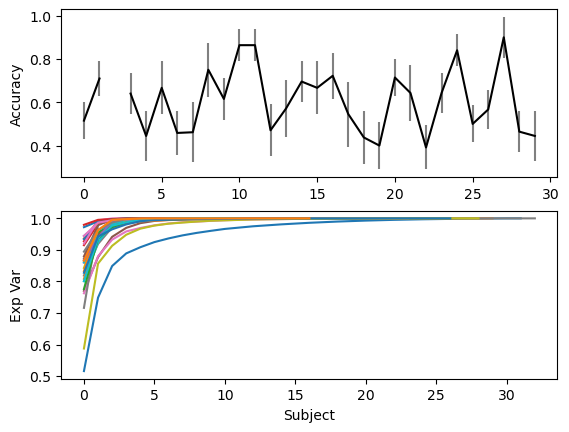

In [48]:
plot_overview(train_acc_avgpwr_rp_pc, acc_avgpwr_rp_pc, ev_avgpwr_rp_pc, dataset, dataset_clip=10)

# Metrics

The metrics here are shown aggregated by subject (stderr bars are on the subject variance). Subjects with fewer than 10 samples are excluded from calculations.

In [49]:
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

## Standard vs DFT
1. Are standard features comparable to deep feature transformer?

In [16]:
with open(f'{save_prefix}_result_avgfreqpwr.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_std = d['acc'] # ch representation of deatures
    res_train_std = d['train_acc'] # ch representation of deatures

with open(f'{save_prefix}_result_topo.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_topo = d['acc'] # topo representation of features
    res_train_topo = d['train_acc'] # topo representation of features

with open(f'{save_prefix}_result_specto_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto = d['acc'] # topo representation of features
    res_train_specto = d['train_acc'] # topo representation of features
    
with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [17]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_std, res_std),
        trainmax2test(res_train_topo, res_topo),
        trainmax2test(res_train_specto, res_specto),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 4 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]
    
    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["AvgFreqPwr", "AvgFreqPwr Topo", "VGG16 Specto", "VGG16 Topo"]

/tmp/ipykernel_133425/66311861.py:8: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


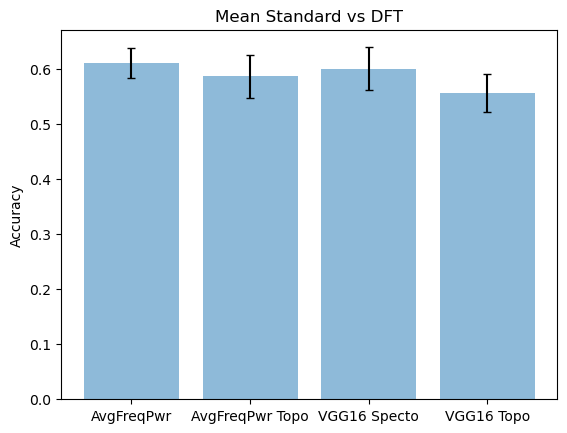

In [18]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Standard vs DFT")
ax.set_ylabel("Accuracy")
plt.show()

## DFT architectures + Pretrained vs Random (Xe) weights
1. Are there any differences between different DFT architectures
2. Do pretrained models provide any benefit over randomly initialized architectures?

In [54]:
with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_vgg16_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_ri = d['acc'] # rand init
    res_train_vgg16_ri = d['train_acc'] # rand init

with open(f'{save_prefix}_result_alexnet.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_pt = d['acc'] # pretrained
    res_train_alexnet_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_alexnet_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_ri = d['acc'] # rand init
    res_train_alexnet_ri = d['train_acc'] # rand init

with open(f'{save_prefix}_result_incepv3.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_pt = d['acc'] # pretrained
    res_train_incepv3_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_incepv3_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_ri = d['acc'] # rand init
    res_train_incepv3_ri = d['train_acc'] # rand init

In [55]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
        trainmax2test(res_train_vgg16_ri, res_vgg16_ri),
        trainmax2test(res_train_alexnet_pt, res_alexnet_pt),
        trainmax2test(res_train_alexnet_ri, res_alexnet_ri),
        trainmax2test(res_train_incepv3_pt, res_incepv3_pt),
        trainmax2test(res_train_incepv3_ri, res_incepv3_ri),
    ]) # 6 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 6 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]

    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["VGG16", "VGG16 Rand", "AlexNet", "AlexNet Rand", "IncepV3", "IncepV3 Rand"]

/tmp/ipykernel_73280/2127535865.py:10: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 6 -> Subjects


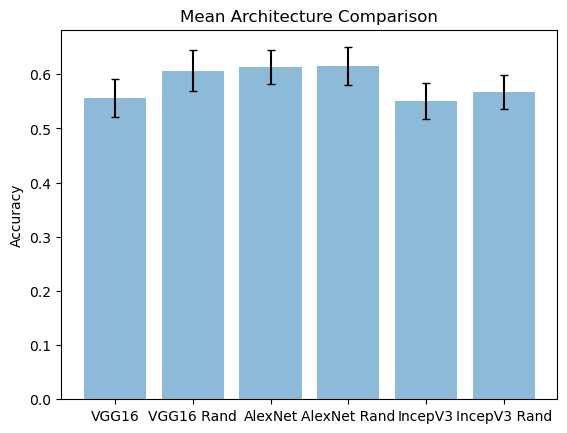

In [56]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()

## Random Projections vs DFT

In [23]:
with open(f'{save_prefix}_result_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_rp = d['acc']
    res_train_rp = d['train_acc']

with open(f'{save_prefix}_result_avgfreqpwr_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_avgfreqpwr_rp_pc = d['acc']
    res_train_avgfreqpwr_rp_pc = d['train_acc']

with open(f'{save_prefix}_result_specto_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto_rp_pc = d['acc']
    res_train_specto_rp_pc = d['train_acc']

with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [24]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_rp, res_rp),
        trainmax2test(res_train_avgfreqpwr_rp_pc, res_avgfreqpwr_rp_pc),
        trainmax2test(res_train_specto_rp_pc, res_specto_rp_pc),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 4 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]

    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["RP(Topo)", "RP(AvgFreq)", "RP(Specto)", "VGG16(Topo)"]

/tmp/ipykernel_133425/4162497519.py:8: RuntimeWarning: Mean of empty slice
  y = np.nanmean(y, axis=-1) # 4 -> Subjects


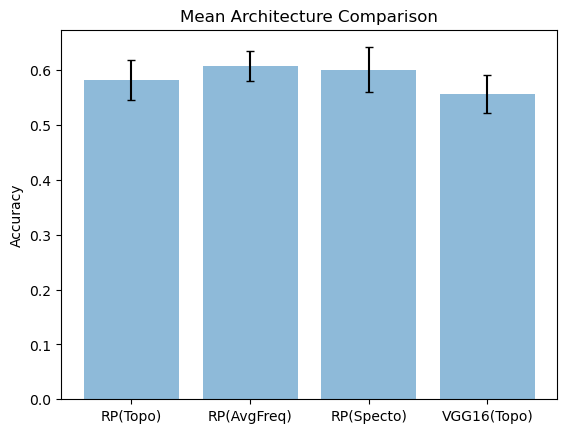

In [25]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()